In [1]:
# !pip install scikit-optimize
# from google.colab import drive
# drive.mount('/content/drive')

# Imports

In [1]:
import time
import timeit
import math

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', message='The objective has been evaluated at point')
warnings.filterwarnings('ignore', message='invalid value encountered in cast')

from IPython.display import display

from functools import reduce
from operator import mul

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr, probplot, shapiro, kstest, norm, anderson, skew, kurtosis

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from scipy.stats import ttest_rel

# Data

## Importing and cleaning

In [73]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car_data.csv')
data = pd.read_csv('car_data_winter2024.csv')

display(data.head())
print()
display(data.describe(include='all'))
print()
print('Null values')
display(data.isnull().sum().sort_values())
print()
print('Unique values')
display(data.nunique().sort_values())

,Price,Year,Generation,Trim,Mileage,Distance,Seller,Owners
0,14750,2022,8,ST-3,50150,43,Trade,NaN
1,12950,2018,8,ST-3,50873,51,Trade,2.0
2,8795,2014,7,ST-3,49500,52,Trade,2.0
3,7250,2015,7,ST-3,62445,45,Private,5.0
4,4995,2014,7,ST-3,81899,133,Trade,4.0


,Price,Year,Generation,Trim,Mileage,Distance,Seller,Owners
count,611.000000,611.000000,611.000000,611,611.000000,611.000000,611,295.000000
unique,NaN,NaN,NaN,2,NaN,NaN,2,NaN
top,NaN,NaN,NaN,ST-3,NaN,NaN,Trade,NaN
freq,NaN,NaN,NaN,378,NaN,NaN,519,NaN
mean,12540.271686,2018.312602,7.566285,NaN,43733.739771,172.700491,NaN,3.115254
std,5430.831951,3.272662,0.495993,NaN,28445.755440,75.856489,NaN,1.355364
min,2895.000000,2013.000000,7.000000,NaN,9.000000,8.000000,NaN,2.000000
25%,7495.000000,2015.000000,7.000000,NaN,16665.500000,134.500000,NaN,2.000000
50%,12109.000000,2018.000000,8.000000,NaN,42000.000000,172.000000,NaN,3.000000
75%,17998.500000,2022.000000,8.000000,NaN,64000.000000,210.000000,NaN,4.000000



Null values


Price           0
Year            0
Generation      0
Trim            0
Mileage         0
Distance        0
Seller          0
Owners        316
dtype: int64


Unique values


Trim            2
Generation      2
Seller          2
Owners          9
Year           12
Distance      212
Price         404
Mileage       515
dtype: int64

In [74]:
# Generation: 7 to 1, 8 to 0 (i.e. mine is 1)
# Trim: ST-3 to 1, ST-2 to 0 (i.e. mine is 1)
# Seller: Private to 1, trade to 0 (i.e. mine is 1)

data['Generation'] = data['Generation'].map({7:1, 8:0})
data['Trim'] = data['Trim'].map({'ST-3':1, 'ST-2':0})
data['Seller'] = data['Seller'].map({'Private':1, 'Trade':0})

display(data.describe(include='all'))

,Price,Year,Generation,Trim,Mileage,Distance,Seller,Owners
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,295.000000
mean,12540.271686,2018.312602,0.433715,0.618658,43733.739771,172.700491,0.150573,3.115254
std,5430.831951,3.272662,0.495993,0.486114,28445.755440,75.856489,0.357925,1.355364
min,2895.000000,2013.000000,0.000000,0.000000,9.000000,8.000000,0.000000,2.000000
25%,7495.000000,2015.000000,0.000000,0.000000,16665.500000,134.500000,0.000000,2.000000
50%,12109.000000,2018.000000,0.000000,1.000000,42000.000000,172.000000,0.000000,3.000000
75%,17998.500000,2022.000000,1.000000,1.000000,64000.000000,210.000000,0.000000,4.000000
max,26995.000000,2024.000000,1.000000,1.000000,139250.000000,472.000000,1.000000,10.000000


In [75]:
def boxplot_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Boxplots for {title}', fontsize=16)
    numeric_columns = data.select_dtypes(include=['number']).columns
    for i, column in enumerate(numeric_columns):
        plt.subplot(2, 4, i + 1)
        data.boxplot(column=[column])
        plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

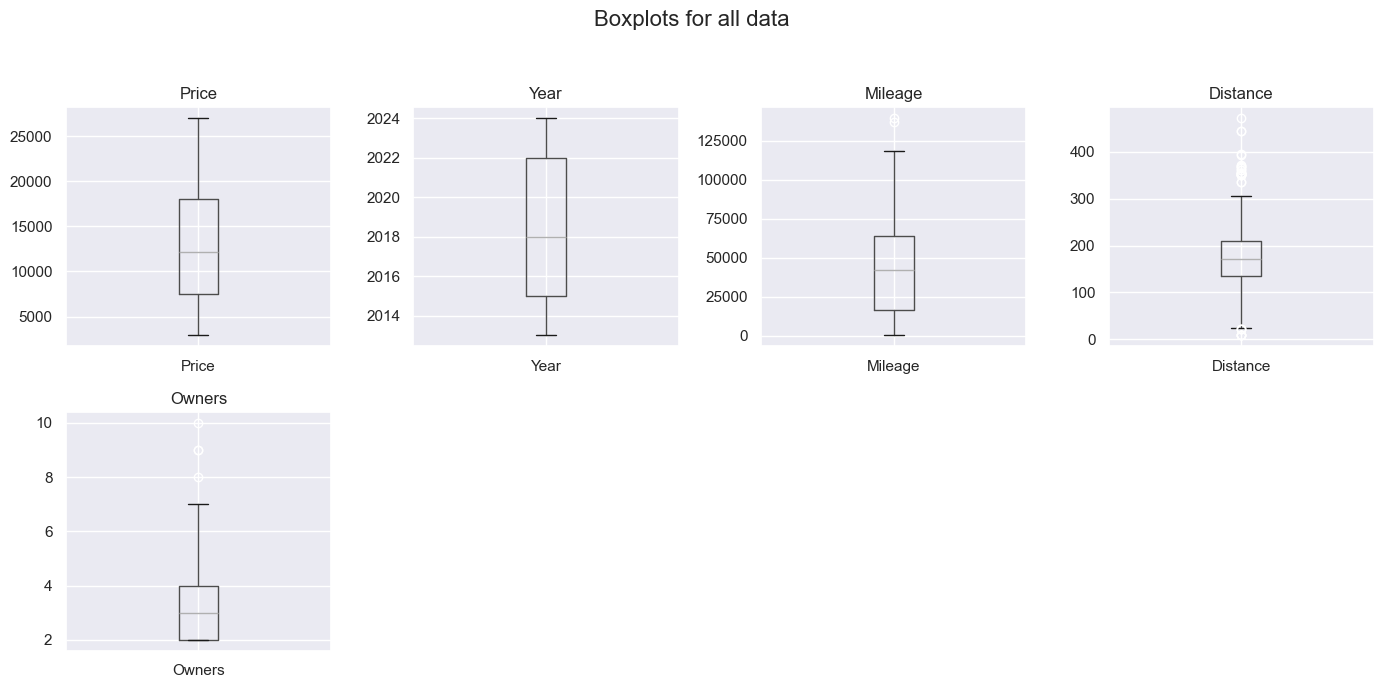

In [76]:
boxplot_all_columns(data[['Price', 'Year', 'Mileage', 'Distance', 'Owners']], 'all data')

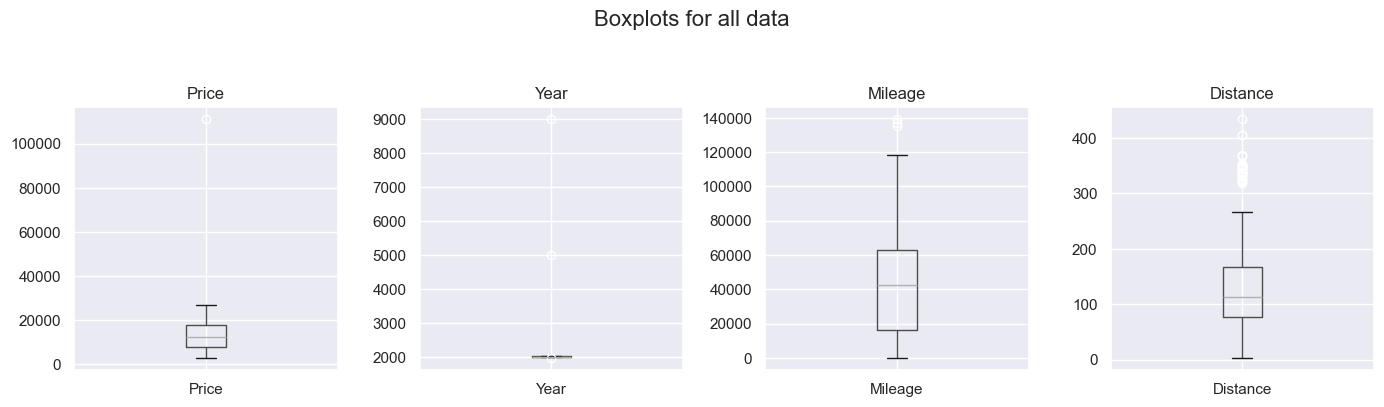

In [9]:
# # Fixed outlier values come from manually checking raw data

# data[data['Year'] == 1100]
# data.loc[17, 'Year'] = 2020

# data[data['Year'] == 2025]
# data.loc[80, 'Year'] = 2016
# data.loc[110, 'Year'] = 2019

# data['Mileage'].sort_values().tail()
# data.drop(index=53, inplace=True)

# boxplot_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')

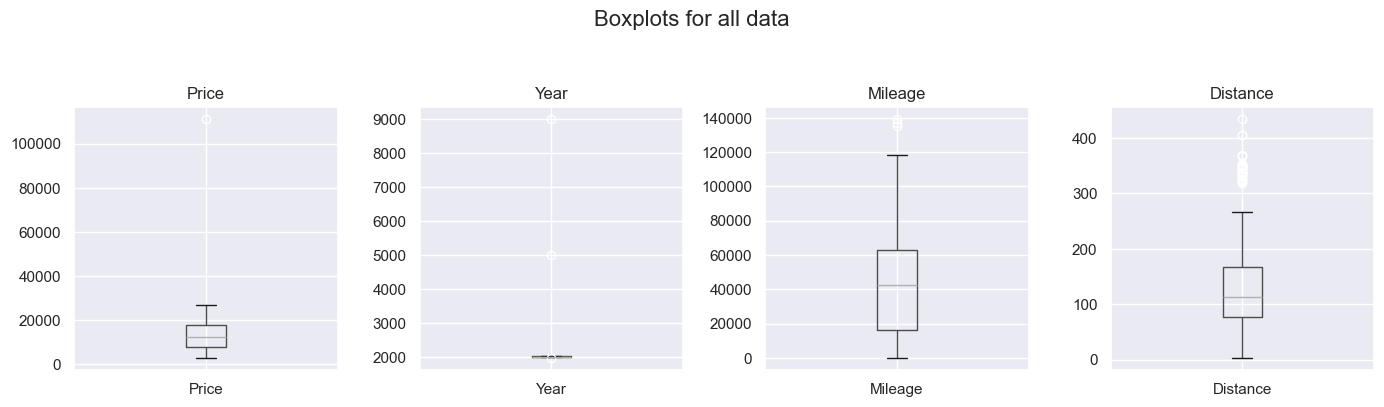

In [10]:
# boxplot_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')

In [11]:
# display(data.describe(include='all'))

,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,709.000000,709.000000,707.000000,709.000000,709.000000,709.000000,709.000000
mean,12864.437236,2032.433004,0.400283,0.593794,43239.836389,127.049365,0.970381
std,6493.107405,284.813672,0.490302,0.491471,28134.639772,78.758636,0.169654
min,2895.000000,1979.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,7699.000000,2016.000000,0.000000,0.000000,16245.000000,77.000000,1.000000
50%,12351.000000,2018.000000,0.000000,1.000000,42300.000000,113.000000,1.000000
75%,18000.000000,2022.000000,1.000000,1.000000,62672.000000,167.000000,1.000000
max,111111.000000,8995.000000,1.000000,1.000000,139250.000000,434.000000,1.000000


## Data splitting

In [77]:
# Data split by categories (generation, trim, seller type)

st3_data = data[data['Trim'] == 1]
st3_data_dropped = st3_data.loc[:, st3_data.nunique() != 1]

gen7_data = data[data['Generation'] == 1]

gen7_st3_data = gen7_data[gen7_data['Trim'] == 1]
gen7_st2_data = gen7_data[gen7_data['Trim'] == 0]

gen7_private_data = gen7_data[gen7_data['Seller'] == 1]
gen7_trade_data = gen7_data[gen7_data['Seller'] == 0]

gen7_st3_private_data = gen7_st3_data[gen7_st3_data['Seller'] == 1]
gen7_st3_trade_data = gen7_st3_data[gen7_st3_data['Seller'] == 0]

gen7_st2_private_data = gen7_st2_data[gen7_st2_data['Seller'] == 1]
gen7_st2_trade_data = gen7_st2_data[gen7_st2_data['Seller'] == 0]

gen8_data = data[data['Generation'] == 0]

gen8_st3_data = gen8_data[gen8_data['Trim'] == 1]
gen8_st2_data = gen8_data[gen8_data['Trim'] == 0]

gen8_private_data = gen8_data[gen8_data['Seller'] == 1]
gen8_trade_data = gen8_data[gen8_data['Seller'] == 0]

gen8_st3_private_data = gen8_st3_data[gen8_st3_data['Seller'] == 1]
gen8_st3_trade_data = gen8_st3_data[gen8_st3_data['Seller'] == 0]

gen8_st2_private_data = gen8_st2_data[gen8_st2_data['Seller'] == 1]
gen8_st2_trade_data = gen8_st2_data[gen8_st2_data['Seller'] == 0]

# gen7_st3_private_data_dropped = gen7_st3_private_data.drop(['Generation', 'Trim', 'Seller'], axis=1) # these are effectively equivalent
gen7_st3_private_data_dropped = gen7_st3_private_data.loc[:, gen7_st3_private_data.nunique() != 1]


In [78]:
gen7_st3_data.describe()

,Price,Year,Generation,Trim,Mileage,Distance,Seller,Owners
count,123.000000,123.000000,123.0,123.0,123.000000,123.000000,123.000000,82.000000
mean,7823.552846,2015.617886,1.0,1.0,64475.699187,174.837398,0.252033,3.036585
std,1839.464820,1.052089,0.0,0.0,22066.313444,71.764571,0.435956,1.070884
min,3750.000000,2014.000000,1.0,1.0,14000.000000,21.000000,0.000000,2.000000
25%,6575.000000,2015.000000,1.0,1.0,50050.000000,135.500000,0.000000,2.000000
50%,7600.000000,2016.000000,1.0,1.0,63000.000000,172.000000,0.000000,3.000000
75%,8995.000000,2016.500000,1.0,1.0,79912.500000,212.500000,0.500000,4.000000
max,12499.000000,2017.000000,1.0,1.0,139250.000000,366.000000,1.000000,6.000000


# Exploratory data analysis

## Price graphs

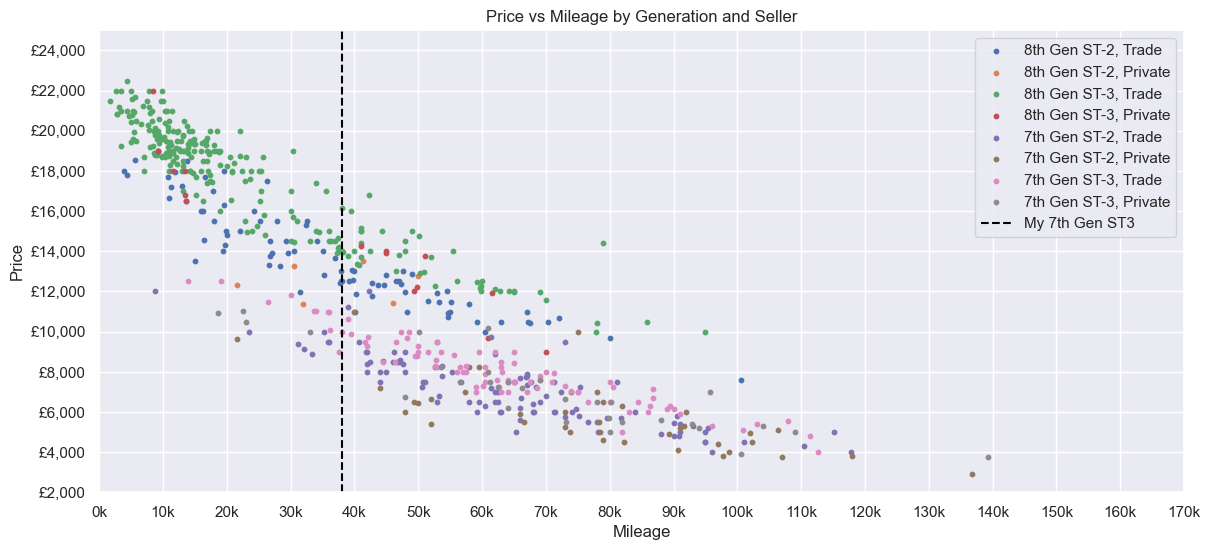

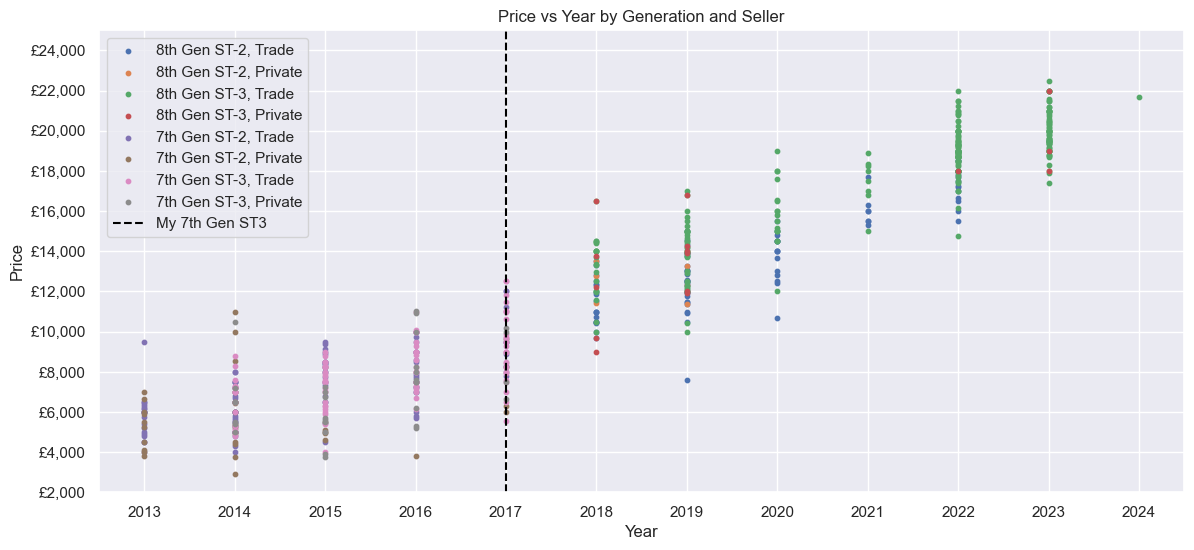

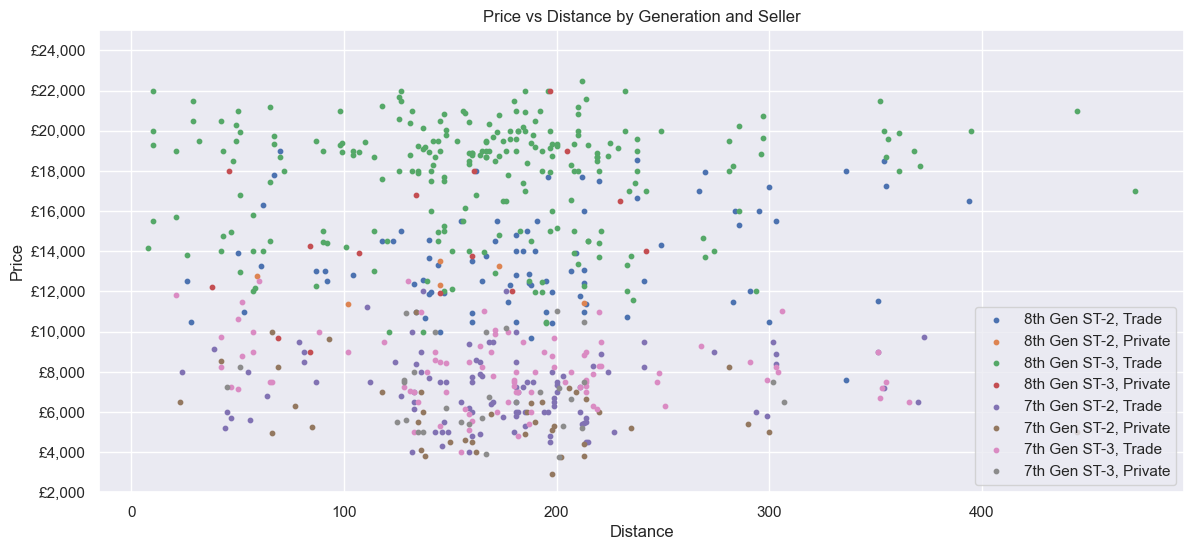

In [79]:
def plot_price_vs(x_col):
    plt.figure(figsize=(14, 6))
    plt.title(f'Price vs {x_col} by Generation and Seller')

    y_gen7_st2_private = gen7_st2_private_data['Price']
    y_gen7_st2_trade = gen7_st2_trade_data['Price']
    x_gen7_st2_private = gen7_st2_private_data[x_col]
    x_gen7_st2_trade = gen7_st2_trade_data[x_col]

    y_gen7_st3_private = gen7_st3_private_data['Price']
    y_gen7_st3_trade = gen7_st3_trade_data['Price']
    x_gen7_st3_private = gen7_st3_private_data[x_col]
    x_gen7_st3_trade = gen7_st3_trade_data[x_col]

    y_gen8_st2_private = gen8_st2_private_data['Price']
    y_gen8_st2_trade = gen8_st2_trade_data['Price']
    x_gen8_st2_private = gen8_st2_private_data[x_col]
    x_gen8_st2_trade = gen8_st2_trade_data[x_col]

    y_gen8_st3_private = gen8_st3_private_data['Price']
    y_gen8_st3_trade = gen8_st3_trade_data['Price']
    x_gen8_st3_private = gen8_st3_private_data[x_col]
    x_gen8_st3_trade = gen8_st3_trade_data[x_col]

    plt.scatter(x_gen8_st2_trade, y_gen8_st2_trade, s=10, label='8th Gen ST-2, Trade')
    plt.scatter(x_gen8_st2_private, y_gen8_st2_private, s=10, label='8th Gen ST-2, Private')

    plt.scatter(x_gen8_st3_trade, y_gen8_st3_trade, s=10, label='8th Gen ST-3, Trade')
    plt.scatter(x_gen8_st3_private, y_gen8_st3_private, s=10, label='8th Gen ST-3, Private')

    plt.scatter(x_gen7_st2_trade, y_gen7_st2_trade, s=10, label='7th Gen ST-2, Trade')
    plt.scatter(x_gen7_st2_private, y_gen7_st2_private, s=10, label='7th Gen ST-2, Private')

    plt.scatter(x_gen7_st3_trade, y_gen7_st3_trade, s=10, label='7th Gen ST-3, Trade')
    plt.scatter(x_gen7_st3_private, y_gen7_st3_private, s=10, label='7th Gen ST-3, Private')

    if x_col == 'Mileage':
        plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
    elif x_col == 'Year':
        plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

    ax = plt.gca()

    plt.ylabel('Price')
    plt.ylim(2000,25000)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))
    def currency_formatter(y, pos):
        return '£{:,.0f}'.format(y)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

    plt.xlabel(f'{x_col}')
    if x_col == 'Mileage':
      plt.xlim(0,170000)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
      def thousands_formatter(x, pos):
          return '{:.0f}k'.format(x / 1000)
      ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    elif x_col == 'Year':
      plt.xlim(2012.5, 2024.5)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(True)
    plt.legend()
    plt.show()

plot_price_vs('Mileage')
plot_price_vs('Year')
plot_price_vs('Distance')

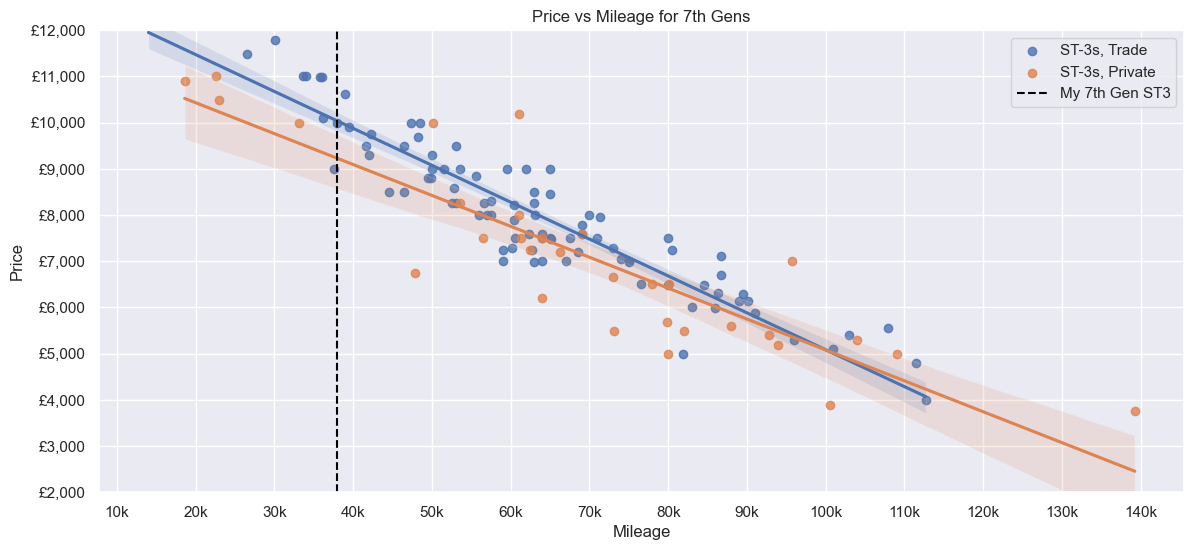

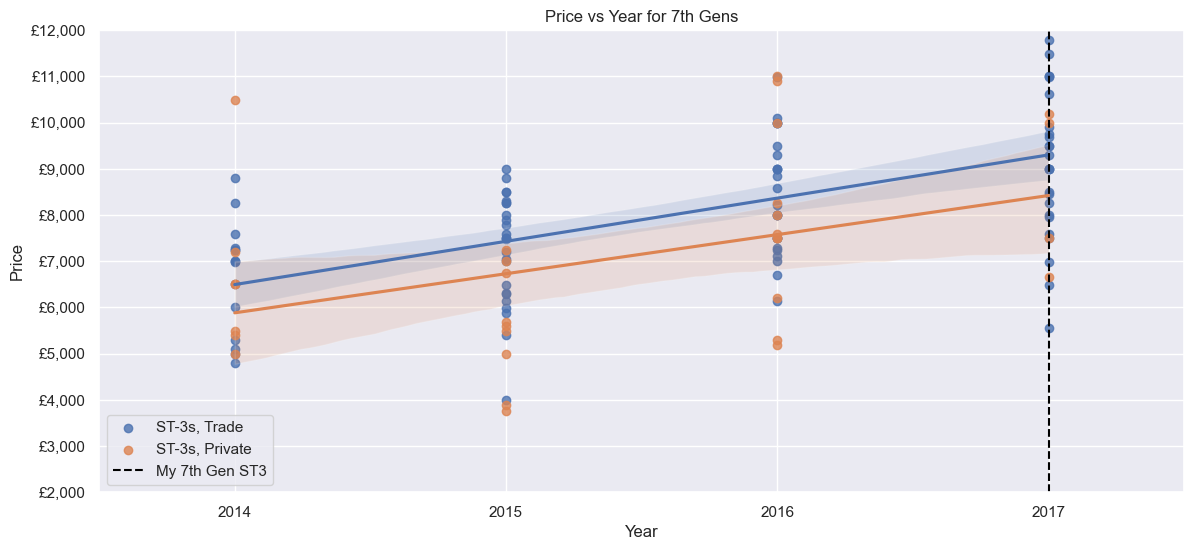

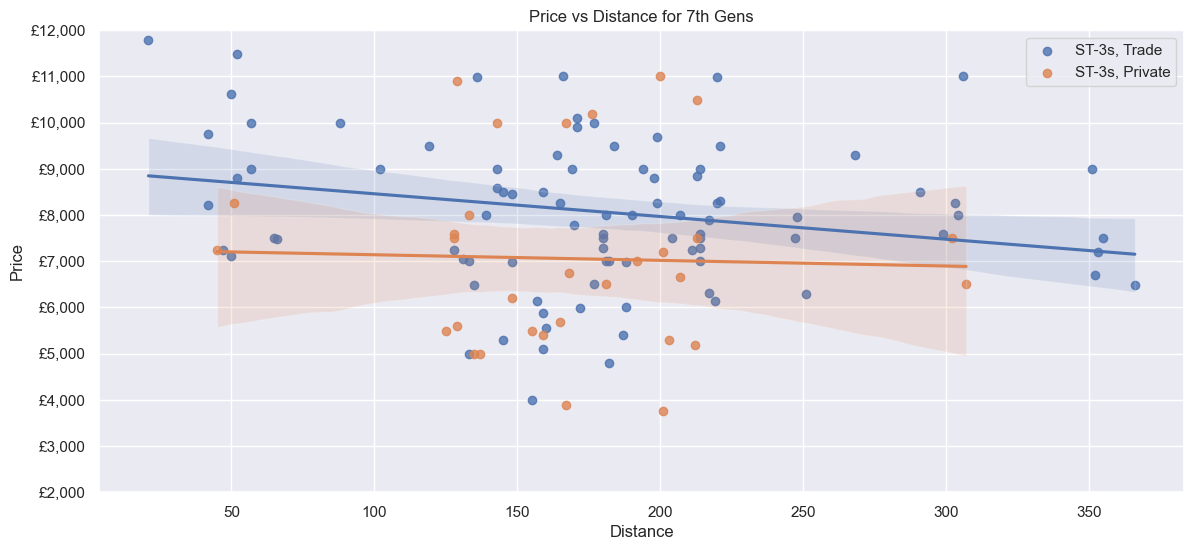

In [80]:
def plot_price_vs_gen7(x_col):
  plt.figure(figsize=(14, 6))
  plt.title(f'Price vs {x_col} for 7th Gens')

  ax = sns.regplot(data=gen7_st3_trade_data, x=x_col, y='Price', label='ST-3s, Trade')
  ax = sns.regplot(data=gen7_st3_private_data, x=x_col, y='Price', label='ST-3s, Private')

  if x_col == 'Mileage':
      plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
  elif x_col == 'Year':
      plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

  plt.ylabel('Price')
  plt.ylim(2000, 12000)
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
  def currency_formatter(y, pos):
      return '£{:,.0f}'.format(y)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

  plt.xlabel(f'{x_col}')
  if x_col == 'Mileage':
    # plt.xlim(10000, 170000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
    def thousands_formatter(x, pos):
        return '{:.0f}k'.format(x / 1000)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
  elif x_col == 'Year':
    plt.xlim(2013.5, 2017.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.grid(True)
  plt.legend()
  plt.show()

plot_price_vs_gen7('Mileage')
plot_price_vs_gen7('Year')
plot_price_vs_gen7('Distance')

## Histograms

In [35]:
def histogram_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Histograms for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      sns.histplot(data[column], kde=True)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

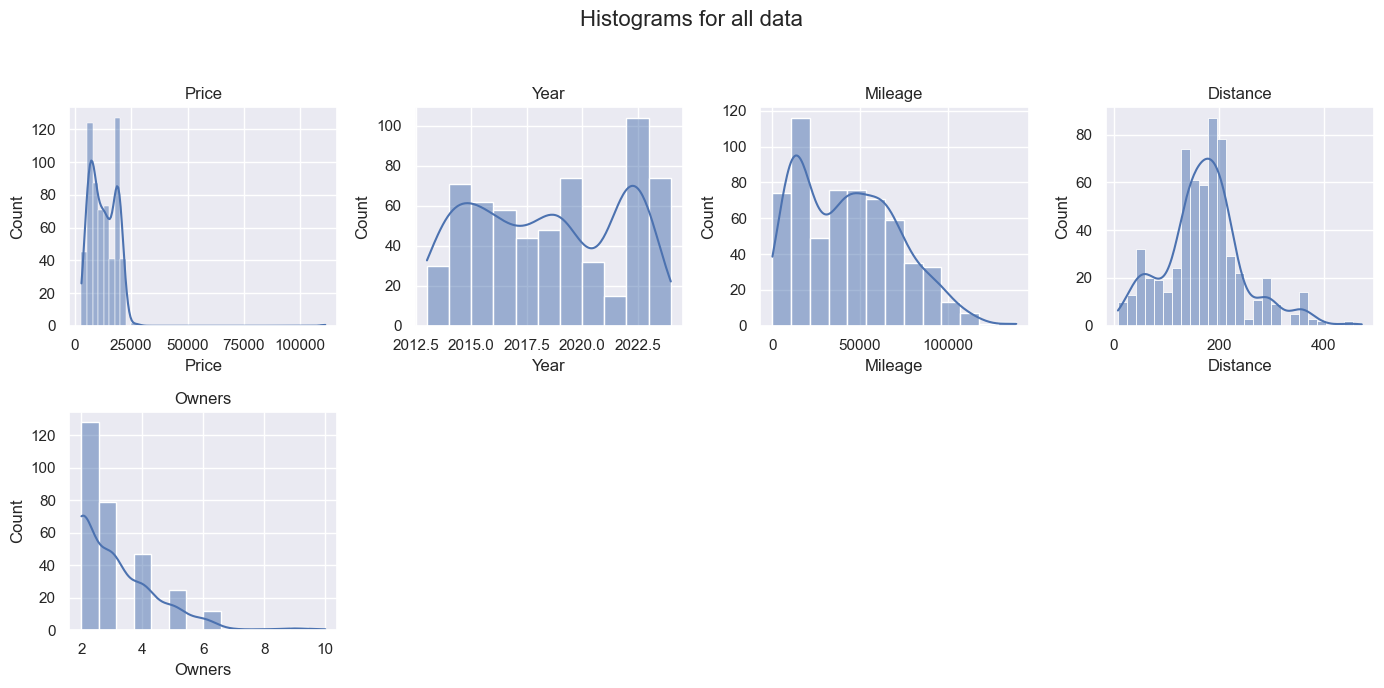

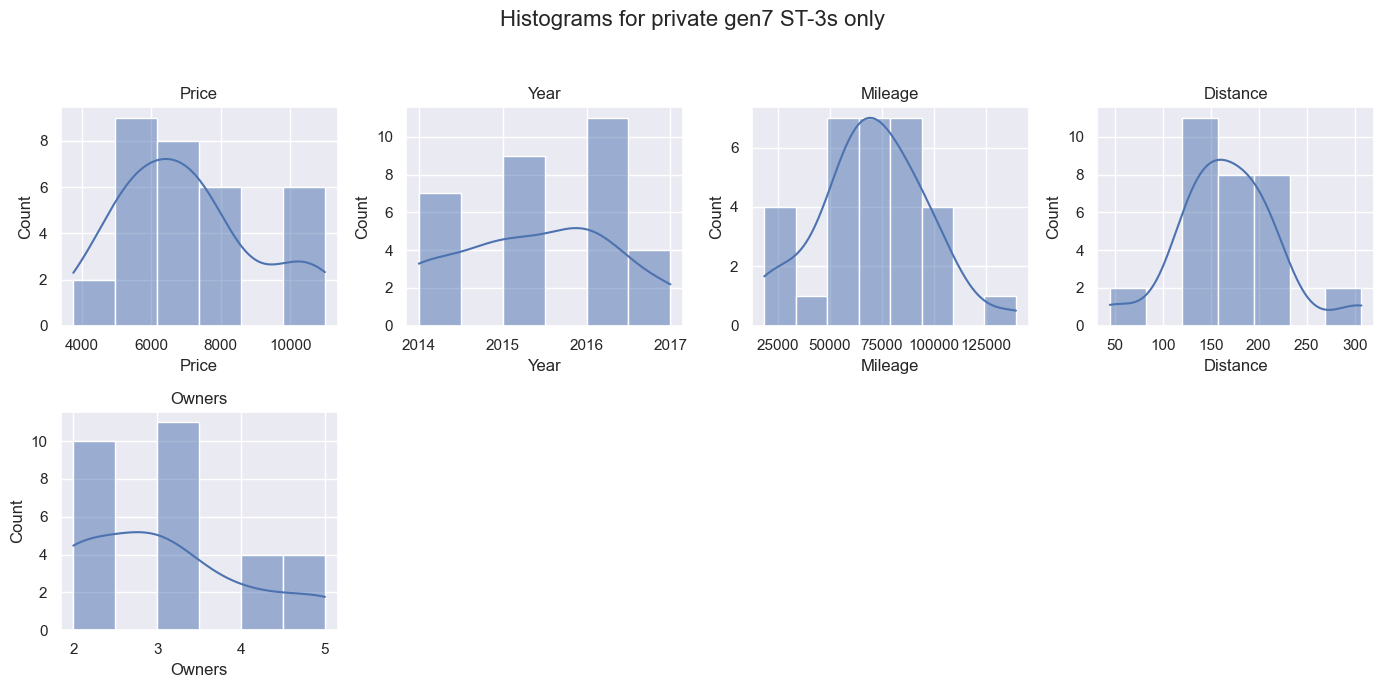

In [36]:
histogram_all_columns(data[['Price', 'Year', 'Mileage', 'Distance', 'Owners']], 'all data')
histogram_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Q-Q plots

In [37]:
def qq_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Q-Q plots for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      probplot(data[column], dist="norm", plot=plt)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

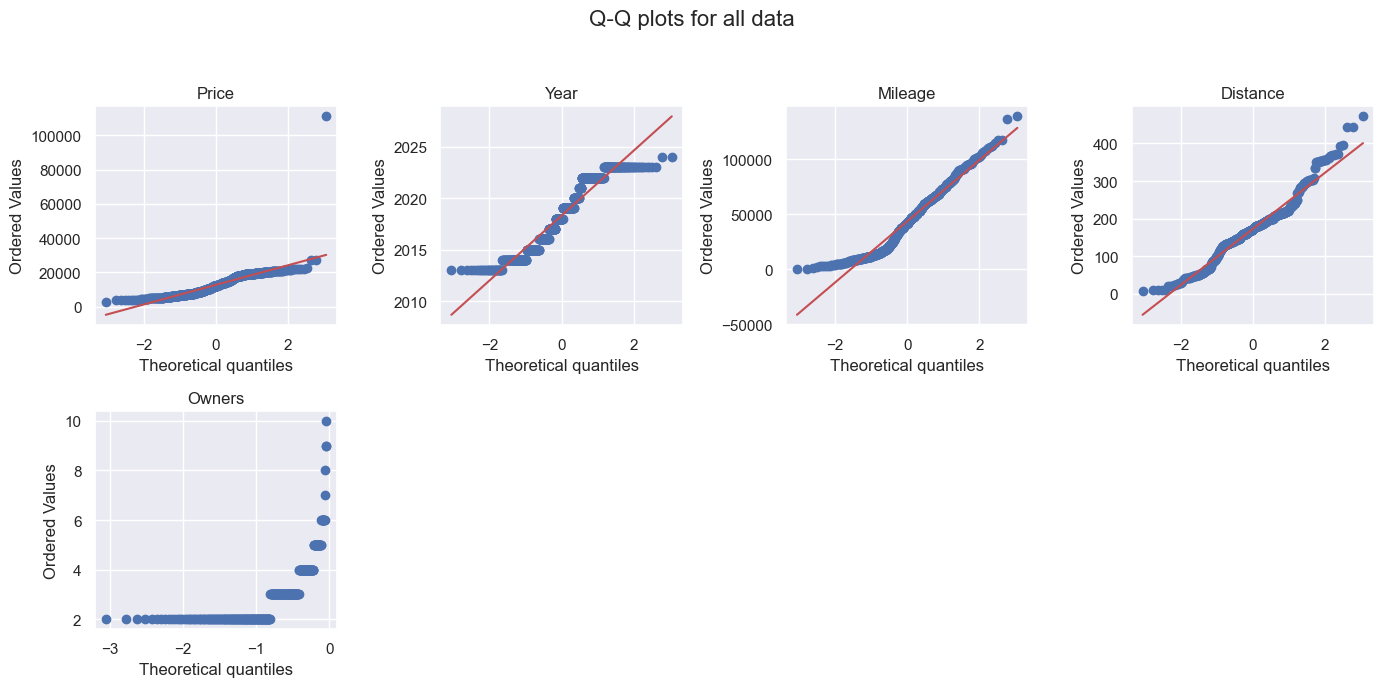

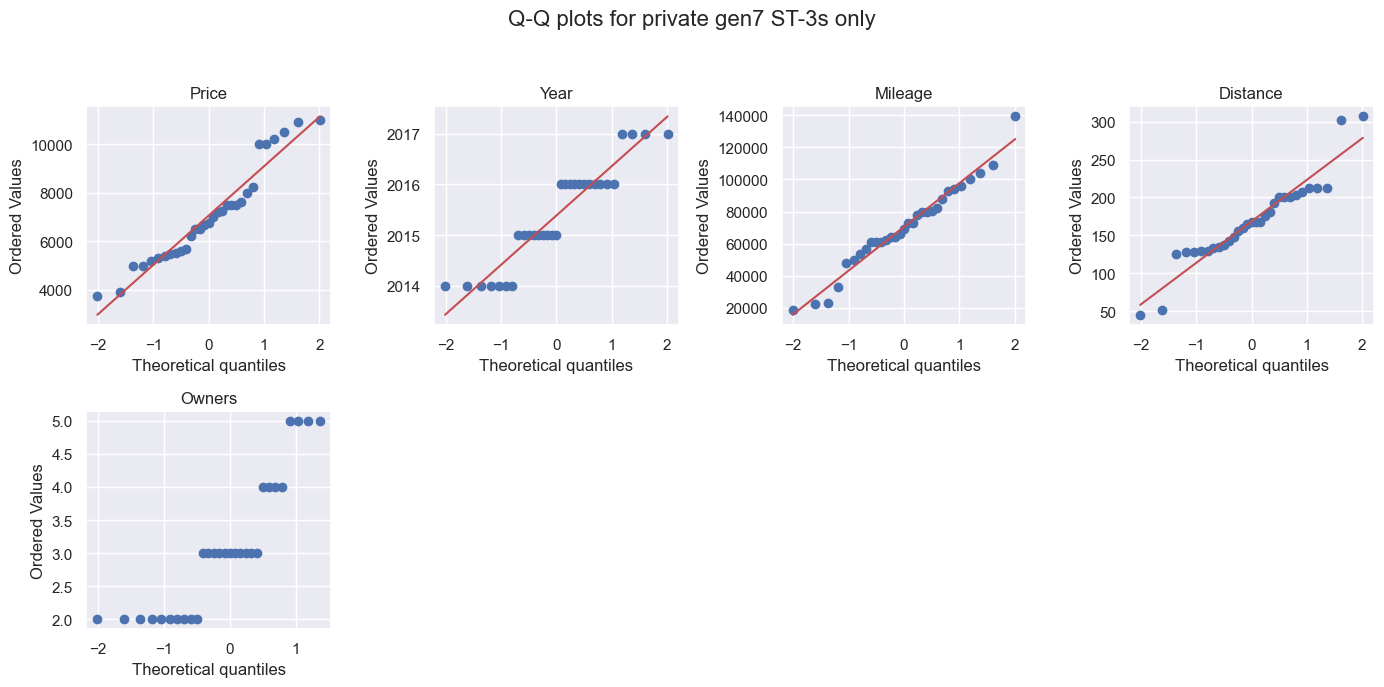

In [38]:
qq_all_columns(data[['Price', 'Year', 'Mileage', 'Distance', 'Owners']], 'all data')
qq_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Normality statistics

In [39]:
def normality_all_columns(data):
    results = []
    for column in data.columns:
      stat_s, p_s = shapiro(data[column])
      stat_ks, p_ks = kstest(data[column], 'norm', args=(data[column].mean(), data[column].std()))
      skewness = skew(data[column])
      kurt = kurtosis(data[column])
      results.append({'Feature': column,
                      'Shapiro statistic': round(stat_s,3), 'Shapiro p-value': round(p_s,3),
                      'KS statistic': round(stat_ks,3), 'KS p-value': round(p_ks,3),
                      'Skew': round(skewness,3), 'Kurtosis': round(kurt,3)})
    results_df = pd.DataFrame(results)
    return results_df

In [40]:
display(normality_all_columns(data))
display(normality_all_columns(gen7_st3_private_data_dropped))

,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.727,0.0,0.090,0.0,5.155,72.575
1,Year,0.918,0.0,0.161,0.0,0.010,-1.353
2,Generation,0.630,0.0,0.376,0.0,0.270,-1.927
3,Trim,0.616,0.0,0.402,0.0,-0.484,-1.766
4,Mileage,0.952,0.0,0.100,0.0,0.465,-0.540
5,Distance,0.965,0.0,0.102,0.0,0.480,0.986
6,Seller,0.429,0.0,0.512,0.0,1.939,1.760
7,Owners,NaN,NaN,NaN,NaN,NaN,NaN


,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.933,0.055,0.136,0.571,0.528,-0.585
1,Year,0.877,0.002,0.216,0.095,0.004,-1.031
2,Mileage,0.975,0.653,0.103,0.863,0.108,0.306
3,Distance,0.925,0.033,0.152,0.433,0.312,1.246
4,Owners,NaN,NaN,NaN,NaN,NaN,NaN


## Correlations

In [41]:
def correlate(data, type):
    corr = data.corr(method=type)
    display(corr)
    plot_corr(corr)

def plot_corr(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True)
    plt.show()

,Price,Year,Generation,Trim,Mileage,Distance,Seller,Owners
Price,1.000000,0.766085,-0.705636,0.330122,-0.728004,-0.010539,-0.215409,-0.307353
Year,0.766085,1.000000,-0.870724,0.426073,-0.817342,0.011829,-0.323233,-0.493352
Generation,-0.705636,-0.870724,1.000000,-0.276028,0.688746,0.020216,0.282297,0.398784
Trim,0.330122,0.426073,-0.276028,1.000000,-0.318929,-0.061120,-0.107163,-0.242888
Mileage,-0.728004,-0.817342,0.688746,-0.318929,1.000000,0.029237,0.317410,0.396421
Distance,-0.010539,0.011829,0.020216,-0.061120,0.029237,1.000000,-0.056383,-0.015429
Seller,-0.215409,-0.323233,0.282297,-0.107163,0.317410,-0.056383,1.000000,0.185105
Owners,-0.307353,-0.493352,0.398784,-0.242888,0.396421,-0.015429,0.185105,1.000000


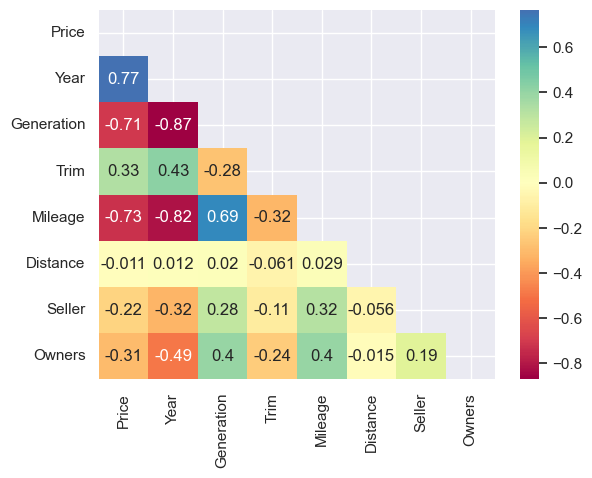

In [42]:
correlate(data, 'pearson')
# correlate(data, 'kendall')
# correlate(data, 'spearman')

,Price,Year,Mileage,Distance,Owners
Price,1.000000,0.415623,-0.882580,-0.033430,-0.384535
Year,0.415623,1.000000,-0.262984,-0.056534,0.074103
Mileage,-0.882580,-0.262984,1.000000,0.086230,0.205523
Distance,-0.033430,-0.056534,0.086230,1.000000,-0.274119
Owners,-0.384535,0.074103,0.205523,-0.274119,1.000000


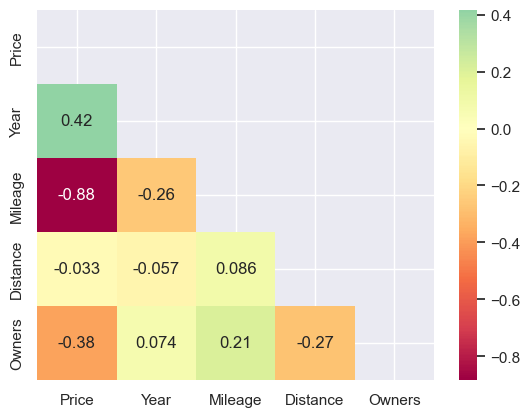

In [43]:
correlate(gen7_st3_private_data_dropped, 'pearson')
# correlate(gen7_st3_private_data_dropped, 'kendall')
# correlate(gen7_st3_private_data_dropped, 'spearman')

### Variance inflation factors

In [44]:
def calculate_vif(variables):
    vif_data = pd.DataFrame()
    vif_data["Features"] = variables.columns
    vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    return vif_data

In [46]:
display(calculate_vif(data[['Year', 'Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]))
display(calculate_vif(data[['Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]))

,Features,VIF
0,Year,12.301052
1,Generation,3.407716
2,Trim,2.942789
3,Mileage,6.843430
4,Distance,6.255826
5,Seller,1.329085


,Features,VIF
0,Generation,3.404151
1,Trim,2.014685
2,Mileage,5.529976
3,Distance,3.469399
4,Seller,1.327647


## Clustering

### Price vs Mileage

In [43]:
data_only_price_and_mileage = data[['Price','Mileage']].copy()
data_only_price_and_mileage_scaled = scale(data_only_price_and_mileage)

In [44]:
def plot_elbow(data):
    wcss =[]
    for i in range(1,6):
        kmeans = KMeans(i)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,6),wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Wi

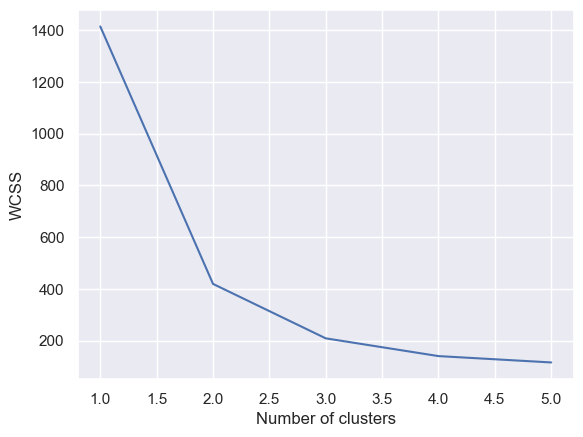

In [45]:
plot_elbow(data_only_price_and_mileage_scaled)

In [46]:
def plot_kmeans(data, data_scaled, x, y, n):
    kmeans = KMeans(n)
    clusters = kmeans.fit_predict(data_scaled)
    plt.scatter(data[x], data[y], c=clusters, cmap='rainbow')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


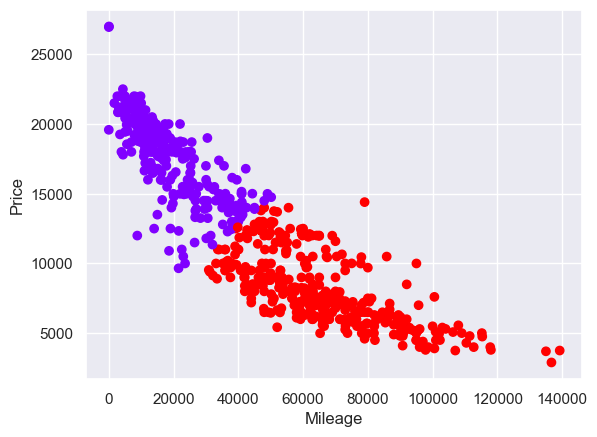

In [47]:
plot_kmeans(data_only_price_and_mileage, data_only_price_and_mileage_scaled, 'Mileage', 'Price', 2)

### Price vs Distance

c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Wi

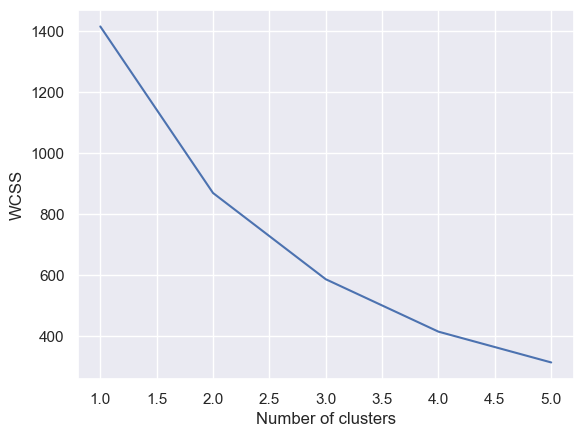

In [48]:
data_only_price_and_distance = data[['Price','Distance']].copy()
data_only_price_and_distance_scaled = scale(data_only_price_and_distance)

plot_elbow(data_only_price_and_distance_scaled)

c:\Users\jgibb\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


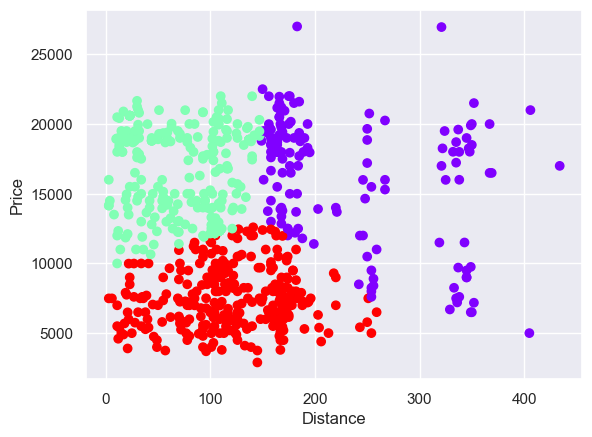

None

In [49]:
display(plot_kmeans(data_only_price_and_distance, data_only_price_and_distance_scaled, 'Distance', 'Price', 3))

# Simple modelling for privately-sold generation 7 ST-3s

## Data

In [50]:
data_simple = gen7_st3_private_data_dropped.copy()
# data_simple.describe()

X_simple = data_simple.copy()
X_simple = X_simple.drop(['Price'], axis=1)
y_simple = data_simple.copy()
y_simple = y_simple['Price']

mine_simple = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1]
})

scaler = StandardScaler()
X_simple_scaled = scaler.fit_transform(X_simple)

## OLS to check for insignificant features

In [51]:
def ols(dataset, xs, pred, title):
    print(title)
    print()
    y = dataset['Price']
    x1 = dataset[xs]
    x = sm.add_constant(x1)
    model_ols = sm.OLS(y,x).fit()
    p = sm.add_constant(pred, has_constant='add')
    predictions = model_ols.predict(p)
    print(f'Prediction: £{int(predictions[0])}')
    print()
    return model_ols.summary()

In [52]:
ols(data_simple, ['Year', 'Mileage', 'Distance'], mine_simple, 'OLS for gen7 ST-3 private data')

OLS for gen7 ST-3 private data

Prediction: £9458



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     40.34
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           4.10e-10
Time:                        09:47:45   Log-Likelihood:                -252.95
No. Observations:                  31   AIC:                             513.9
Df Residuals:                      27   BIC:                             519.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.053e+05    3.5e+05     -2.301      0.029   -1.52e+06   -8.72e+04
Year         405.1383    173.584      2.334      0.027      48.974     761.302
Mileage       -0.0632      0.006     -9.769      0.000      -0.077      -0.050
Distance       1.8157      3.011      0.603      0.552      -4.363       7.994
==============================================================================
Omnibus:                        0.230   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.416
Skew:                           0.136   Prob(JB):                        0.812
Kurtosis:                       2.502   Cond. No.                     1.62e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Remove distance as insignificant

In [53]:
data_simple_no_distance = data_simple.copy()
data_simple_no_distance = data_simple_no_distance.drop(['Distance'], axis=1)

X_simple_no_distance = data_simple_no_distance.copy()
X_simple_no_distance = X_simple_no_distance.drop(['Price'], axis=1)
y_simple_no_distance = data_simple_no_distance.copy()
y_simple_no_distance = y_simple_no_distance['Price']

scaler_no_distance = StandardScaler()
X_simple_no_distance_scaled = scaler_no_distance.fit_transform(X_simple_no_distance)

mine_simple_no_distance = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000]
})

In [54]:
ols(data_simple_no_distance, ['Year', 'Mileage'], mine_simple_no_distance, 'Gen7 ST-3 private data, no distance')

Gen7 ST-3 private data, no distance

Prediction: £9747



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     61.73
Date:                Sun, 29 Dec 2024   Prob (F-statistic):           5.45e-11
Time:                        09:47:48   Log-Likelihood:                -253.16
No. Observations:                  31   AIC:                             512.3
Df Residuals:                      28   BIC:                             516.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.976e+05   3.46e+05     -2.307      0.029   -1.51e+06   -8.94e+04
Year         401.4515    171.493      2.341      0.027      50.164     752.739
Mileage       -0.0630      0.006     -9.864      0.000      -0.076      -0.050
==============================================================================
Omnibus:                        0.367   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.508
Skew:                           0.207   Prob(JB):                        0.776
Kurtosis:                       2.530   Cond. No.                     1.61e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## VIF to check for covariation

In [55]:
calculate_vif(data_simple_no_distance[['Year', 'Mileage']])

,Features,VIF
0,Year,9.209525
1,Mileage,9.209525


## Basic linear regressions

In [56]:
# Unsplit_no_distance

model_lr_simple_unsplit_no_distance = LinearRegression()
model_lr_simple_unsplit_no_distance.fit(X_simple_no_distance, y_simple_no_distance)
model_lr_simple_unsplit_no_distance_prediction = model_lr_simple_unsplit_no_distance.predict(mine_simple_no_distance)[0]

# split_no_distance

X_simple_no_distance_train, X_simple_no_distance_test, y_simple_no_distance_train, y_simple_no_distance_test = train_test_split(X_simple_no_distance, y_simple_no_distance, test_size=0.1, random_state=42)

model_lr_simple_split_no_distance = LinearRegression()
model_lr_simple_split_no_distance.fit(X_simple_no_distance_train, y_simple_no_distance_train)

model_lr_simple_split_no_distance_predictions = model_lr_simple_split_no_distance.predict(X_simple_no_distance_test).astype(int)
mae_lr_simple_split_no_distance = mean_absolute_error(y_simple_no_distance_test, model_lr_simple_split_no_distance_predictions)
mse_lr_simple_split_no_distance = mean_squared_error(y_simple_no_distance_test, model_lr_simple_split_no_distance_predictions)

model_lr_simple_split_no_distance_prediction = model_lr_simple_split_no_distance.predict(mine_simple_no_distance)[0]

# Cross Validate

cv = 10

mae_lr_simple_cv_split_no_distance = cross_val_score(model_lr_simple_split_no_distance, X_simple_no_distance_train, y_simple_no_distance_train, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_split_no_distance = cross_val_score(model_lr_simple_split_no_distance, X_simple_no_distance_train, y_simple_no_distance_train, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_split_no_distance = cross_val_score(model_lr_simple_split_no_distance, X_simple_no_distance_train, y_simple_no_distance_train, cv=cv, scoring='r2')

# Prints

print(f'Prediction using unsplit data:\t£{int(model_lr_simple_unsplit_no_distance_prediction)}')
print(f'Prediction using split data:\t£{int(model_lr_simple_split_no_distance_prediction)}')
print()
print(f'MAE:\t\t{int(mae_lr_simple_split_no_distance)}')
print(f'MSE:\t\t{int(mse_lr_simple_split_no_distance)}')
print()
print(f'CV Best Mean MAE:\t{int(-mae_lr_simple_cv_split_no_distance.mean())}')
print(f'CV Best Mean MSE:\t{int(-mse_lr_simple_cv_split_no_distance.mean())}')
print(f'CV Best Mean R²:\t{r2_lr_simple_cv_split_no_distance.mean():.3f}')

model_lr_simple_summary = pd.DataFrame(X_simple_no_distance.columns.values, columns=['Features'])
model_lr_simple_summary['Weights (unsplitr)'] = model_lr_simple_unsplit_no_distance.coef_
model_lr_simple_summary['Weights (split)'] = model_lr_simple_split_no_distance.coef_
display(model_lr_simple_summary)

Prediction using unsplit data:	£10221
Prediction using split data:	£10166

MAE:		441
MSE:		361256

CV Best Mean MAE:	465
CV Best Mean MSE:	395627
CV Best Mean R²:	0.856


,Features,Weights (unsplitr),Weights (split)
0,Year,401.624247,379.238885
1,Mileage,-0.069455,-0.067996


## Lasso, ridge, elastic net regressions

In [57]:
lasso_model = Lasso()
ridge_model = Ridge()
en_model = ElasticNet()

cv = 10

la_scores = cross_val_score(lasso_model, X_simple_no_distance_scaled, y_simple_no_distance, cv=cv, scoring='neg_mean_absolute_error')
print(f'Lasso CV Mean MAE:\t\t{-int(la_scores.mean())}')
r_scores = cross_val_score(ridge_model, X_simple_no_distance_scaled, y_simple_no_distance, cv=cv, scoring='neg_mean_absolute_error')
print(f'Ridge CV Mean MAE:\t\t{-int(r_scores.mean())}')
en_scores = cross_val_score(en_model, X_simple_no_distance_scaled, y_simple_no_distance, cv=cv, scoring='neg_mean_absolute_error')
print(f'Elastic Net CV Mean MAE:\t{-int(en_scores.mean())}')

alpha_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

param_grid = {'alpha': alpha_values}
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_lasso.fit(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_lasso_best = grid_search_lasso.best_estimator_
test_score_lasso = grid_search_lasso_best.score(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_lasso_best.fit(X_simple_no_distance_train, y_simple_no_distance_train)
grid_search_lasso_prediction = grid_search_lasso_best.predict(mine_simple_no_distance)[0]

param_grid = {'alpha': alpha_values}
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_ridge.fit(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_ridge_best = grid_search_ridge.best_estimator_
test_score_ridge = grid_search_ridge_best.score(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_ridge_best.fit(X_simple_no_distance_train, y_simple_no_distance_train)
gird_search_ridge_prediction = grid_search_ridge_best.predict(mine_simple_no_distance)[0]

l1_ratios = np.linspace(0, 1, 11)
param_grid_en = {'alpha': alpha_values, 'l1_ratio': l1_ratios}
grid_search_en = GridSearchCV(en_model, param_grid_en, cv=cv, scoring='neg_mean_absolute_error')
grid_search_en.fit(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_en_best = grid_search_en.best_estimator_
test_score_en = grid_search_en_best.score(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_en_best.fit(X_simple_no_distance_train, y_simple_no_distance_train)
gird_search_en_prediction = grid_search_en_best.predict(mine_simple_no_distance)[0]
print()
print(f"Elastic Net best l1 ratio value: {grid_search_en.best_params_['l1_ratio']}")

results_lre_simple = {
    'Metric': ['Alpha', 'CV MAE', 'CV R²', 'Prediction'],
    'Lasso': [
        f"{grid_search_lasso.best_params_['alpha']}",
        f"{-int(grid_search_lasso.best_score_)}",
        f"{test_score_lasso:.3f}",
        f"£{int(grid_search_lasso_prediction)}"
    ],
    'Ridge': [
        f"{grid_search_ridge.best_params_['alpha']}",
        f"{-int(grid_search_ridge.best_score_)}",
        f"{test_score_ridge:.3f}",
        f"£{int(gird_search_ridge_prediction)}"
    ],
    'Elastic Net': [
        f"{grid_search_en.best_params_['alpha']}",
        f"{-int(grid_search_en.best_score_)}",
        f"{test_score_en:.3f}",
        f"£{int(gird_search_en_prediction)}"
    ]
}
results_lre_simple_df = pd.DataFrame(results_lre_simple)
display(results_lre_simple_df)


Lasso CV Mean MAE:		462
Ridge CV Mean MAE:		463
Elastic Net CV Mean MAE:	621

Elastic Net best l1 ratio value: 1.0


,Metric,Lasso,Ridge,Elastic Net
0,Alpha,100,1,100
1,CV MAE,461,463,461
2,CV R²,0.889,0.894,0.889
3,Prediction,£10073,£10163,£10073


## Leave-one-out cross validation (LOOCV)

In [58]:
loo = LeaveOneOut()
model_loo = LinearRegression()

predictions_loo = []
actual_prices = []

for train_index, test_index in loo.split(X_simple_no_distance):
    X_simple_no_distance_train, X_test = X_simple_no_distance.iloc[train_index], X_simple_no_distance.iloc[test_index]
    y_simple_no_distance_train, y_test = y_simple_no_distance.iloc[train_index], y_simple_no_distance.iloc[test_index]
    model_loo.fit(X_simple_no_distance_train, y_simple_no_distance_train)
    y_simple_no_distance_pred = model_loo.predict(X_simple_no_distance_test)
    predictions_loo.append(y_simple_no_distance_pred[0])
    actual_prices.append(y_simple_no_distance_test.values[0])

mae_loo = mean_absolute_error(actual_prices, predictions_loo)
mse_loo = mean_squared_error(actual_prices, predictions_loo)
print(f'MAE: {int(mae_loo)}')
print(f'MAE: {int(mse_loo)}')
print()

model_loo.fit(X_simple_no_distance, y_simple_no_distance)
print(f'Prediction: £{int(model_loo.predict(mine_simple_no_distance)[0])}')

MAE: 108
MAE: 11978

Prediction: £10221


## Remove distance and year

In [59]:
data_simple_no_distance_no_year = data_simple_no_distance.copy()
data_simple_no_distance_no_year = data_simple_no_distance_no_year.drop(['Year'], axis=1)

X_simple_no_distance_no_year = data_simple_no_distance_no_year.copy()
X_simple_no_distance_no_year = X_simple_no_distance_no_year.drop(['Price'], axis=1)
y_simple_no_distance_no_year = data_simple_no_distance_no_year.copy()
y_simple_no_distance_no_year = y_simple_no_distance_no_year['Price']

scaler_no_distance_no_year = StandardScaler()
X_simple_no_distance_no_year_scaled = scaler_no_distance_no_year.fit_transform(X_simple_no_distance_no_year)

mine_simple_no_distance_no_year = pd.DataFrame({
    'Mileage': [38000]
})

In [60]:
ols(data_simple_no_distance_no_year, ['Mileage'], mine_simple_no_distance_no_year, 'Gen7 ST-3 private data, no distance no year')

Gen7 ST-3 private data, no distance no year

Prediction: £9880



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     659.9
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           1.84e-49
Time:                        21:27:52   Log-Likelihood:                -934.57
No. Observations:                 117   AIC:                             1873.
Df Residuals:                     115   BIC:                             1879.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.28e+04    201.762     63.425      0.000    1.24e+04    1.32e+04
Mileage       -0.0767      0.003    -25.688      0.000      -0.083      -0.071
==============================================================================
Omnibus:                        3.411   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                3.516
Skew:                          -0.132   Prob(JB):                        0.172
Kurtosis:                       3.807   Cond. No.                     2.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
# Unsplit

model_lr_simple_unsplit_no_distance_no_year = LinearRegression()
model_lr_simple_unsplit_no_distance_no_year.fit(X_simple_no_distance_no_year, y_simple_no_distance_no_year)
model_lr_simple_unsplit_no_distance_no_year_prediction = model_lr_simple_unsplit_no_distance_no_year.predict(mine_simple_no_distance_no_year)[0]

# Split

X_simple_no_distance_no_year_train, X_simple_no_distance_no_year_test, y_simple_no_distance_no_year_train, y_simple_no_distance_no_year_test = train_test_split(X_simple_no_distance_no_year, y_simple_no_distance_no_year, test_size=0.1, random_state=42)

model_lr_simple_split_no_distance_no_year = LinearRegression()
model_lr_simple_split_no_distance_no_year.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)

model_lr_simple_split_no_distance_no_year_predictions = model_lr_simple_split_no_distance_no_year.predict(X_simple_no_distance_no_year_test).astype(int)
mae_lr_simple_split_no_distance_no_year = mean_absolute_error(y_simple_no_distance_no_year_test, model_lr_simple_split_no_distance_no_year_predictions)
mse_lr_simple_split_no_distance_no_year = mean_squared_error(y_simple_no_distance_no_year_test, model_lr_simple_split_no_distance_no_year_predictions)

model_lr_simple_split_no_distance_no_year_prediction = model_lr_simple_split_no_distance_no_year.predict(mine_simple_no_distance_no_year)[0]

# Cross Validate

cv = 10

mae_lr_simple_cv_split_no_distance_no_year = cross_val_score(model_lr_simple_split_no_distance_no_year, X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_split_no_distance_no_year = cross_val_score(model_lr_simple_split_no_distance_no_year, X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_split_no_distance_no_year = cross_val_score(model_lr_simple_split_no_distance_no_year, X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train, cv=cv, scoring='r2')

# Prints

print(f'Prediction using unsplit data:\t£{int(model_lr_simple_unsplit_no_distance_no_year_prediction)}')
print(f'Prediction using split data:\t£{int(model_lr_simple_split_no_distance_no_year_prediction)}')
print()
print(f'MAE:\t\t{int(mae_lr_simple_split_no_distance_no_year)}')
print(f'MSE:\t\t{int(mse_lr_simple_split_no_distance_no_year)}')
print()
print(f'CV Best Mean MAE:\t{int(-mae_lr_simple_cv_split_no_distance_no_year.mean())}')
print(f'CV Best Mean MSE:\t{int(-mse_lr_simple_cv_split_no_distance_no_year.mean())}')
print(f'CV Best Mean R²:\t{r2_lr_simple_cv_split_no_distance_no_year.mean():.3f}')

model_lr_simple_summary_no_distance_no_year = pd.DataFrame(X_simple_no_distance_no_year.columns.values, columns=['Features'])
model_lr_simple_summary_no_distance_no_year['Weights (unsplitr)'] = model_lr_simple_unsplit_no_distance_no_year.coef_
model_lr_simple_summary_no_distance_no_year['Weights (split)'] = model_lr_simple_split_no_distance_no_year.coef_
display(model_lr_simple_summary_no_distance_no_year)

Prediction using unsplit data:	£9880
Prediction using split data:	£9840

MAE:		603
MSE:		606936

CV Best Mean MAE:	554
CV Best Mean MSE:	523611
CV Best Mean R²:	0.810


,Features,Weights (unsplitr),Weights (split)
0,Mileage,-0.076741,-0.074423


In [62]:
lasso_model_no_distance_no_year = Lasso()
ridge_model_no_distance_no_year = Ridge()
en_model_no_distance_no_year = ElasticNet()

cv = 10

la_scores_no_distance_no_year = cross_val_score(lasso_model_no_distance_no_year, X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year, cv=cv, scoring='neg_mean_absolute_error')
print(f'Lasso CV Mean MAE:\t\t{-int(la_scores_no_distance_no_year.mean())}')
r_scores_no_distance_no_year = cross_val_score(ridge_model_no_distance_no_year, X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year, cv=cv, scoring='neg_mean_absolute_error')
print(f'Ridge CV Mean MAE:\t\t{-int(r_scores_no_distance_no_year.mean())}')
en_scores_no_distance_no_year = cross_val_score(en_model_no_distance_no_year, X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year, cv=cv, scoring='neg_mean_absolute_error')
print(f'Elastic Net CV Mean MAE:\t{-int(en_scores_no_distance_no_year.mean())}')

alpha_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

param_grid = {'alpha': alpha_values}
grid_search_lasso_no_distance_no_year = GridSearchCV(lasso_model_no_distance_no_year, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_lasso_no_distance_no_year.fit(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_lasso_no_distance_no_year_best = grid_search_lasso_no_distance_no_year.best_estimator_
test_score_lasso_no_distance_no_year = grid_search_lasso_no_distance_no_year_best.score(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_lasso_no_distance_no_year_best.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)
grid_search_lasso_no_distance_no_year_prediction = grid_search_lasso_no_distance_no_year_best.predict(mine_simple_no_distance_no_year)[0]

param_grid = {'alpha': alpha_values}
grid_search_ridge_no_distance_no_year = GridSearchCV(ridge_model_no_distance_no_year, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_ridge_no_distance_no_year.fit(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_ridge_no_distance_no_year_best = grid_search_ridge_no_distance_no_year.best_estimator_
test_score_ridge_no_distance_no_year = grid_search_ridge_no_distance_no_year_best.score(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_ridge_no_distance_no_year_best.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)
gird_search_ridge_no_distance_no_year_prediction = grid_search_ridge_no_distance_no_year_best.predict(mine_simple_no_distance_no_year)[0]

l1_ratios = np.linspace(0, 1, 11)
param_grid_en = {'alpha': alpha_values, 'l1_ratio': l1_ratios}
grid_search_en_no_distance_no_year = GridSearchCV(en_model_no_distance_no_year, param_grid_en, cv=cv, scoring='neg_mean_absolute_error')
grid_search_en_no_distance_no_year.fit(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_en_no_distance_no_year_best = grid_search_en_no_distance_no_year.best_estimator_
test_score_en_no_distance_no_year = grid_search_en_no_distance_no_year_best.score(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_en_no_distance_no_year_best.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)
gird_search_en_no_distance_no_year_prediction = grid_search_en_no_distance_no_year_best.predict(mine_simple_no_distance_no_year)[0]
print()
print(f"Elastic Net best l1 ratio value: {grid_search_en_no_distance_no_year.best_params_['l1_ratio']}")

results_lre_simple_no_distance_no_year = {
    'Metric': ['Alpha', 'CV MAE', 'CV R²', 'Prediction'],
    'Lasso': [
        f"{grid_search_lasso_no_distance_no_year.best_params_['alpha']}",
        f"{-int(grid_search_lasso_no_distance_no_year.best_score_)}",
        f"{test_score_lasso_no_distance_no_year:.3f}",
        f"£{int(grid_search_lasso_no_distance_no_year_prediction)}"
    ],
    'Ridge': [
        f"{grid_search_ridge_no_distance_no_year.best_params_['alpha']}",
        f"{-int(grid_search_ridge_no_distance_no_year.best_score_)}",
        f"{test_score_ridge_no_distance_no_year:.3f}",
        f"£{int(gird_search_ridge_no_distance_no_year_prediction)}"
    ],
    'Elastic Net': [
        f"{grid_search_en_no_distance_no_year.best_params_['alpha']}",
        f"{-int(grid_search_en_no_distance_no_year.best_score_)}",
        f"{test_score_en_no_distance_no_year:.3f}",
        f"£{int(gird_search_en_no_distance_no_year_prediction)}"
    ]
}
results_lre_simple_no_distance_no_year_df = pd.DataFrame(results_lre_simple_no_distance_no_year)
display(results_lre_simple_no_distance_no_year_df)

Lasso CV Mean MAE:		555
Ridge CV Mean MAE:		555
Elastic Net CV Mean MAE:	732

Elastic Net best l1 ratio value: 0.5


,Metric,Lasso,Ridge,Elastic Net
0,Alpha,10,1,0.01
1,CV MAE,555,555,555
2,CV R²,0.852,0.852,0.852
3,Prediction,£9840,£9840,£9840


## Relative year

In [63]:
data_simple_relative_year = gen7_st3_private_data_dropped.copy()
data_simple_relative_year = data_simple_relative_year.drop(['Distance'], axis=1)
data_simple_relative_year['Year'] = data_simple_relative_year['Year'] - 2014
data_simple_relative_year.describe()

X_simple_relative_year = data_simple_relative_year.copy()
X_simple_relative_year = X_simple_relative_year.drop(['Price'], axis=1)
y_simple_relative_year = data_simple_relative_year.copy()
y_simple_relative_year = y_simple_relative_year['Price']

mine_simple_relative_year = pd.DataFrame({
    'Year': [3],
    'Mileage': [38000]
})

scaler_relative_year = StandardScaler()
X_simple_relative_year_scaled = scaler_relative_year.fit_transform(X_simple_relative_year)

In [64]:
ols(data_simple_relative_year, ['Year', 'Mileage'], mine_simple_relative_year, 'Gen7 ST-3 private data, no distance, relative year')

Gen7 ST-3 private data, no distance, relative year

Prediction: £10221



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     478.7
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           3.44e-56
Time:                        21:27:56   Log-Likelihood:                -915.10
No. Observations:                 117   AIC:                             1836.
Df Residuals:                     114   BIC:                             1844.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.166e+04    241.570     48.250      0.000    1.12e+04    1.21e+04
Year         401.6242     59.863      6.709      0.000     283.036     520.212
Mileage       -0.0695      0.003    -25.138      0.000      -0.075      -0.064
==============================================================================
Omnibus:                        5.631   Durbin-Watson:                   2.251
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                6.713
Skew:                          -0.256   Prob(JB):                       0.0349
Kurtosis:                       4.056   Cond. No.                     2.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# More complex modelling for the entire dataset

## Data

In [55]:
X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

mine_all = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Seller': [1],
    'Owners': [3]
})

## OLS

In [ ]:
ols(data, ['Year','Generation','Trim','Mileage','Distance','Seller','Owners'], mine_all, 'All data, all columns')

## Quick predictions

In [67]:
models_quick = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

In [68]:
preds = []

for name, model in models_quick.items():
    model.fit(X,y)
    pred = model.predict(mine_all).astype(int)[0]
    preds.append(pred)
    print(f'{name.ljust(30)}£{pred}')

print('-'*36)
print(f'MEAN{"":<26}£{int(np.mean(preds))}')

model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = models_quick['Linear Regression'].coef_
model_lr_summary

Linear Regression             £11331
Lasso Regression              £11332
Ridge Regression              £11343
Decision Tree Regressor       £11225
Random Forest Regressor       £10551
Gradient Boosting Regressor   £10609
XGBoost Regressor             £10427
------------------------------------
MEAN                          £10974


,Features,Weights
0,Year,712.791127
1,Generation,-1902.873907
2,Trim,1028.241249
3,Mileage,-0.076761
4,Distance,0.429706
5,Seller,383.668265


## Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
models_split = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_split = pd.DataFrame()

for name, model in models_split.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = int(mean_absolute_error(y_test, y_pred))
        mse = int(mean_squared_error(y_test, y_pred))
        r2 = round(r2_score(y_test, y_pred),3)
        pred = f'£{int(model.predict(mine_all)[0])}'
        results_split = pd.concat([results_split, pd.DataFrame({'Model': [name], 'MAE': [mae], 'MSE': [mse], 'R²': [r2], 'Prediction': [pred]})], ignore_index=True)
    except ValueError:
        continue
results_split.sort_values('MAE')

,Model,MAE,MSE,R²,Prediction
2,XGBoost Regressor,826,1538158,0.947,£10407
1,Random Forest Regressor,1001,4146927,0.858,£10591
0,Decision Tree Regressor,1023,1841012,0.937,£10630


## Cross validation

In [62]:
cv = 10

In [ ]:
results_cv = pd.DataFrame()

for name, model in models_split.items():
    maes = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all)[0])}'
    results_cv = pd.concat([results_cv, pd.DataFrame({'CV\'d Model': [name], 'Mean MAE': [maes_mean], 'MAE STD': [maes_std], 'Mean MSE': [mses_mean], 'MSE STD': [mses_std], 'Mean R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv.sort_values('Mean MAE')

## RandomizedSearchCV

In [74]:
n_iter = 10

### Gradient boosting

In [75]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,50))
max_depth_range = list(range(1,11))
param_grid_gb = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}
total_combinations = reduce(mul, [len(v) for v in param_grid_gb.values()])
print(f'Total parameter combinations: {total_combinations}')

model_gb = GradientBoostingRegressor(random_state=42)
rs_gb = RandomizedSearchCV(model_gb, param_distributions=param_grid_gb, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_gb.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_gb.best_score_)}')
print(f'Params: {rs_gb.best_params_}')
model_gb_rscv_best = GradientBoostingRegressor(random_state=42, **rs_gb.best_params_)
print(f'Mean R²: {round(cross_val_score(model_gb_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_gb_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_gb_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 3800
Best MAE: 689
Params: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}
Mean R²: 0.958
Prediction: £10582


### XGBoost

In [55]:
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}
total_combinations = reduce(mul, [len(v) for v in param_grid_xgb.values()])
print(f'Total parameter combinations: {total_combinations:,}')

model_xgb = XGBRegressor(random_state=42)
rs_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_grid_xgb, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_xgb.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_xgb.best_score_)}')
print(f'Params: {rs_xgb.best_params_}')
model_xgb_rscv_best = XGBRegressor(random_state=42, **rs_xgb.best_params_)
print(f'Mean R²: {round(cross_val_score(model_xgb_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_xgb_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_xgb_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 77,760
Best MAE: 626
Params: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
R²: 0.973
Prediction: £9857


### Random forest

In [56]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'friedman_mse']
}
total_combinations = reduce(mul, [len(v) for v in param_grid_rf.values()])
print(f'Total parameter combinations: {total_combinations}')

model_rf = RandomForestRegressor(random_state=42)
rs_rf = RandomizedSearchCV(model_rf, param_distributions=param_grid_rf, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_rf.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_rf.best_score_)}')
print(f'Params: {rs_rf.best_params_}')
model_rf_rscv_best = RandomForestRegressor(random_state=42, **rs_rf.best_params_)
print(f'Mean R²: {round(cross_val_score(model_rf_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_rf_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_rf_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 3200
Best MAE: 708
Params: {'n_estimators': 150, 'min_samples_split': 11, 'max_depth': 16, 'criterion': 'squared_error'}
R²: 0.965
Prediction: £10031


## GridSearchCVs

### Gradient boosting

In [57]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,100))
max_depth_range = list(range(1,11))
param_grid_gb_gs = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_gb = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_gb.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = reduce(mul, [len(v) for v in param_grid_gb_gs.values()])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 3.3954 seconds
Total number of fits: 2000 x 15 = 30,000
Approximate time for all fits: 169.77 minutes


In [58]:
# model_gb = GradientBoostingRegressor(random_state=42)

# grid_search_gb_mae = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_gb_mae.fit(X_train, y_train)
# print(f'grid_search_gb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_gb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_gb_mae.best_score_:.2f}")

# grid_search_gb_mse = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_gb_mse.fit(X_train, y_train)
# print(f'grid_search_gb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_gb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_gb_mse.best_score_:.2f}")

# grid_search_gb_r2 = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_gb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_gb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_gb_r2.best_score_:.2f}")

### XGBoost

In [59]:
param_grid_xgb_gs = {
    'n_estimators': [500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0],
    'reg_lambda': [0.4, 0.5, 0.6],
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_xgb_timer = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_xgb_timer.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
# fits = reduce(mul, [len(v) for v in param_grid_xgb.values()])
fits = math.prod(len(i) for i in param_grid_xgb_gs.values())
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 2.8034 seconds
Total number of fits: 9000 x 15 = 135,000
Approximate time for all fits: 630.76 minutes


In [60]:
# model_xgb = XGBRegressor(random_state=42)

# grid_search_xgb_mae = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_xgb_mae.fit(X_train, y_train)
# print(f'grid_search_xgb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_xgb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_xgb_mae.best_score_:.2f}")

# grid_search_xgb_mse = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_xgb_mse.fit(X_train, y_train)
# print(f'grid_search_xgb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_xgb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_xgb_mse.best_score_:.2f}")

# grid_search_xgb_r2 = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_xgb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_xgb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_xgb_r2.best_score_:.2f}")

### Random forest

In [61]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf_gs = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

params = { 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 10, 'criterion': 'squared_error' }
model_rf = RandomForestRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_rf.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = reduce(mul, [len(v) for v in param_grid_rf_gs.values()])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 2.1680 seconds
Total number of fits: 3200 x 15 = 48,000
Approximate time for all fits: 173.44 minutes


In [62]:
# model_rf = RandomForestRegressor(random_state=42)

# grid_search_rf_mae = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_rf_mae.fit(X_train, y_train)
# print(f'grid_search_rf_mae complete')

# grid_search_rf_mse = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_rf_mse.fit(X_train, y_train)
# print(f'grid_search_rf_mse complete')

# grid_search_rf_r2 = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_rf_r2.fit(X_train, y_train)
# print(f'grid_search_rf_r2 complete')
# print()

# print(f"Best Parameters (MAE): {grid_search_rf_mae.best_params_}")
# print(f"Best Parameters (MSE): {grid_search_rf_mse.best_params_}")
# print(f"Best Parameters (R²): {grid_search_rf_r2.best_params_}")
# print()
# print(f"Best Score (MAE): {-grid_search_rf_mae.best_score_:.2f}")
# print(f"Best Score (MSE): {-grid_search_rf_mse.best_score_:.2f}")
# print(f"Best Score (R²): {grid_search_rf_r2.best_score_:.2f}")

## BayesSearchCV

In [65]:
n_iter = 200

### Gradient boosting

In [ ]:
param_grid_gb = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10), 
    'max_features': Categorical([1, 2, 'sqrt', 'log2']),
    'subsample': (0.01, 1.0),
    'alpha': (0.01, 0.99),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_gb = GradientBoostingRegressor(random_state=42)
opt_gb = BayesSearchCV(model_gb, param_grid_gb, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring, verbose=1)
opt_gb.fit(X_train, y_train)
model_gb_bscv_best = opt_gb.best_estimator_
print(f'Best MAE: {int(-opt_gb.best_score_)}')
print(f'Params: {dict(opt_gb.best_params_)}')
print(f'Number of interations: {n_iter}')
model_gb_bscv_best_r2 = round(cross_val_score(model_gb_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'Mean R²: {model_gb_bscv_best_r2}')
model_gb_bscv_best.fit(X_train, y_train)
model_gb_bscv_best_prediction = model_gb_bscv_best.predict(mine_all)[0]
print(f'Prediction: £{int(model_gb_bscv_best_prediction)}')

### XGBoost

In [67]:
param_grid_xgb = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_xgb = XGBRegressor(random_state=42)
opt_xgb = BayesSearchCV(model_xgb, param_grid_xgb, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring, verbose=1)
opt_xgb.fit(X_train, y_train)
model_xgb_bscv_best = opt_xgb.best_estimator_
print(f'Best MAE: {int(-opt_xgb.best_score_)}')
# print(f'Best R²: {round(-opt_xgb.best_score_,3)}') # for r2 (default)s scoring
print(f'Params: {dict(opt_xgb.best_params_)}')
print(f'Number of interations: {n_iter}')
model_xgb_bscv_best_r2 = round(cross_val_score(model_xgb_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'Mean R²: {model_xgb_bscv_best_r2}')
model_xgb_bscv_best.fit(X_train, y_train)
model_xgb_bscv_best_prediction = model_xgb_bscv_best.predict(mine_all)[0]
print(f'Prediction: £{int(model_xgb_bscv_best_prediction)}')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

### Random forest

In [ ]:
param_grid_rf = {
    'n_estimators': (50, 300),
    'max_depth': (1, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (None, 'sqrt', 'log2'),
    'criterion': ['squared_error', 'friedman_mse'],
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_rf = RandomForestRegressor(random_state=42)
opt_rf = BayesSearchCV(model_rf, param_grid_rf, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring) # n_jobs=1
opt_rf.fit(X_train, y_train)
model_rf_bscv_best = opt_rf.best_estimator_
print(f'Best MAE: {int(-opt_rf.best_score_)}')
print(f'Parameters: {dict(opt_rf.best_params_)}')
print(f'Number of interations: {n_iter}')
model_rf_bscv_best_r2 = round(cross_val_score(model_rf_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_rf_bscv_best_r2}')
model_rf_bscv_best.fit(X_train, y_train)
model_rf_bscv_best_prediction = model_rf_bscv_best.predict(mine_all)[0]
print(f'Prediction: £{int(model_rf_bscv_best_prediction)}')

## Fewer features

### No distance

In [68]:
data_no_distance = data.copy()
data_no_distance = data_no_distance.drop(['Distance'], axis=1)
data_no_distance

X_no_distance = data_no_distance.drop(['Price'], axis=1).copy()
y_no_distance = data_no_distance['Price'].copy()

X_no_distance_train, X_no_distance_test, y_no_distance_train, y_no_distance_test = train_test_split(X_no_distance, y_no_distance, test_size=0.2, random_state=42)

mine_all_no_distance = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Seller': [1],
    'Owners': [3]
})

models_no_distance = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_distance = pd.DataFrame()

for name, model in models_no_distance.items():
    try:
        model.fit(X_no_distance,y_no_distance)
        maes = cross_val_score(model, X_no_distance_train, y_no_distance_train, cv=cv, scoring='neg_mean_absolute_error')
        maes_mean = -int(maes.mean())
        maes_std = int(maes.std())
        mses = cross_val_score(model, X_no_distance_train, y_no_distance_train, cv=cv, scoring='neg_mean_squared_error')
        mses_mean = -int(mses.mean())
        mses_std = int(mses.std())
        r2s = cross_val_score(model, X_no_distance_train, y_no_distance_train, cv=cv, scoring='r2')
        r2s_mean = round(r2s.mean(),3)
        r2s_std = round(r2s.std(),3)
        pred = f'£{int(model.predict(mine_all_no_distance)[0])}'
        results_cv_no_distance = pd.concat([results_cv_no_distance, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)
    except ValueError:
        continue

results_cv_no_distance.sort_values('MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
1,Random Forest Regressor,1163,638,27608066,58306074,0.640,0.374,£10289
2,XGBoost Regressor,1254,796,38588390,62307007,0.253,1.115,£10253
0,Decision Tree Regressor,1425,997,61381800,92111424,-0.729,3.177,£9899


In [68]:
param_grid_gb_no_distance = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10), 
    'max_features': Categorical([1, 2, 'sqrt', 'log2']),
    'subsample': (0.01, 1.0),
    'alpha': (0.01, 0.99),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_gb_no_distance = GradientBoostingRegressor(random_state=42)
opt_gb_no_distance = BayesSearchCV(model_gb_no_distance, param_grid_gb_no_distance, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_gb_no_distance.fit(X_no_distance_train, y_no_distance_train)
model_gb_no_distance_bscv_best = opt_gb_no_distance.best_estimator_
print(f'Best MAE: {int(-opt_gb_no_distance.best_score_)}')
print(f'Params: {dict(opt_gb_no_distance.best_params_)}')
print(f'Number of interations: {n_iter}')
model_gb_no_distance_bscv_best_r2 = round(cross_val_score(model_gb_no_distance_bscv_best, X_no_distance_train, y_no_distance_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_gb_no_distance_bscv_best_r2}')
model_gb_no_distance_bscv_best.fit(X_no_distance_train, y_no_distance_train)
model_gb_no_distance_bscv_best_prediction = model_gb_no_distance_bscv_best.predict(mine_all_no_distance)[0]
print(f'Prediction: £{int(model_gb_no_distance_bscv_best_prediction)}')

Best MAE: 602
Params: {'alpha': 0.5141872275033554, 'learning_rate': 0.05211112149474534, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.9012263075106356}
Number of interations: 200
R²: 0.97525
Prediction: £9622


In [70]:
param_grid_xgb_no_distance = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0),
}
scoring=make_scorer(lambda y_no_distance_true, y_pred: -mean_absolute_error(y_no_distance_true, y_pred))

model_xgb_no_distance = XGBRegressor(random_state=42)
opt_xgb_no_distance = BayesSearchCV(model_xgb_no_distance, param_grid_xgb_no_distance, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_xgb_no_distance.fit(X_no_distance_train, y_no_distance_train)
model_xgb_no_distance_bscv_best = opt_xgb_no_distance.best_estimator_
print(f'Best MAE: {int(-opt_xgb_no_distance.best_score_)}')
# print(f'Best R²: {round(-opt_xgb_no_distance.best_score_,3)}') # for r2 (default)s scoring
print(f'Params: {dict(opt_xgb_no_distance.best_params_)}')
print(f'Number of interations: {n_iter}')
model_xgb_no_distance_bscv_best_r2 = round(cross_val_score(model_xgb_no_distance_bscv_best, X_no_distance_train, y_no_distance_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_xgb_no_distance_bscv_best_r2}')
model_xgb_no_distance_bscv_best.fit(X_no_distance_train, y_no_distance_train)
model_xgb_no_distance_bscv_best_prediction = model_xgb_no_distance_bscv_best.predict(mine_all_no_distance)[0]
print(f'Prediction: £{int(model_xgb_no_distance_bscv_best_prediction)}')

Best MAE: 914
Params: {'colsample_bytree': 1.0, 'gamma': 0.23378572797407107, 'learning_rate': 0.013398721296420758, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 2000, 'reg_alpha': 0.5434703121313388, 'reg_lambda': 0.33900953112789123, 'subsample': 0.10408205241923528}
Number of interations: 200
R²: 0.86697
Prediction: £11538


### No year

In [70]:
data_no_year = data.copy()
data_no_year = data_no_year.drop(['Year'], axis=1)
data_no_year

X_no_year = data_no_year.drop(['Price'], axis=1).copy()
y_no_year = data_no_year['Price'].copy()

X_no_year_train, X_no_year_test, y_no_year_train, y_no_year_test = train_test_split(X_no_year, y_no_year, test_size=0.2, random_state=42)

mine_all_no_year = pd.DataFrame({
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Seller': [1]
})

models_no_year = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_year = pd.DataFrame()

for name, model in models_no_year.items():
    model.fit(X_no_year,y_no_year)
    maes = cross_val_score(model, X_no_year_train, y_no_year_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_no_year_train, y_no_year_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_no_year_train, y_no_year_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all_no_year)[0])}'
    results_cv_no_year = pd.concat([results_cv_no_year, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv_no_year.sort_values('MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,801,102,1214332,323874,0.957,0.008,£9452
4,Random Forest Regressor,868,105,1356654,370375,0.951,0.010,£10018
6,XGBoost Regressor,897,96,1535003,320013,0.945,0.009,£10332
3,Decision Tree Regressor,1031,77,2093843,396154,0.925,0.012,£10000
0,Linear Regression,1182,67,2201547,238080,0.920,0.005,£10608
1,Lasso Regression,1182,67,2201656,237534,0.920,0.005,£10615
2,Ridge Regression,1182,65,2202744,230722,0.920,0.005,£10641


### No distance no year

In [71]:
data_no_distance_no_year = data.copy()
data_no_distance_no_year = data_no_distance_no_year.drop(['Year', 'Distance'], axis=1)
data_no_distance_no_year

X_no_distance_no_year = data_no_distance_no_year.drop(['Price'], axis=1).copy()
y_no_distance_no_year = data_no_distance_no_year['Price'].copy()

X_no_distance_no_year_train, X_no_distance_no_year_test, y_no_distance_no_year_train, y_no_distance_no_year_test = train_test_split(X_no_distance_no_year, y_no_distance_no_year, test_size=0.2, random_state=42)

mine_all_no_distance_no_year = pd.DataFrame({
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Seller': [1]
})

models_no_distance_no_year = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_distance_no_year = pd.DataFrame()

for name, model in models_no_distance_no_year.items():
    model.fit(X_no_distance_no_year,y_no_distance_no_year)
    maes = cross_val_score(model, X_no_distance_no_year_train, y_no_distance_no_year_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_no_distance_no_year_train, y_no_distance_no_year_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_no_distance_no_year_train, y_no_distance_no_year_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all_no_distance_no_year)[0])}'
    results_cv_no_distance_no_year = pd.concat([results_cv_no_distance_no_year, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv_no_distance_no_year.sort_values('MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,799,103,1202398,296173,0.957,0.007,£9064
4,Random Forest Regressor,874,93,1449733,300652,0.948,0.007,£8488
6,XGBoost Regressor,892,106,1558868,348247,0.944,0.009,£9437
3,Decision Tree Regressor,1031,89,2101860,425191,0.925,0.009,£7250
0,Linear Regression,1180,67,2193062,239276,0.921,0.005,£10702
1,Lasso Regression,1180,67,2193133,238813,0.921,0.005,£10709
2,Ridge Regression,1180,65,2194017,232529,0.921,0.005,£10735


### No distance no owners

In [81]:
data_no_distance_no_owners = data.copy()
data_no_distance_no_owners = data_no_distance_no_owners.drop(['Distance', 'Owners'], axis=1)

X_no_distance_no_owners = data_no_distance_no_owners.drop(['Price'], axis=1).copy()
y_no_distance_no_owners = data_no_distance_no_owners['Price'].copy()

X_no_distance_no_owners_train, X_no_distance_no_owners_test, y_no_distance_no_owners_train, y_no_distance_no_owners_test = train_test_split(X_no_distance_no_owners, y_no_distance_no_owners, test_size=0.2, random_state=42)

mine_all_no_distance_no_owners = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Seller': [1]
})

models_no_distance_no_owners = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_distance_no_owners = pd.DataFrame()
for name, model in models_no_distance_no_owners.items():
    try:
        model.fit(X_no_distance_no_owners,y_no_distance_no_owners)
        maes = cross_val_score(model, X_no_distance_no_owners_train, y_no_distance_no_owners_train, cv=cv, scoring='neg_mean_absolute_error')
        maes_mean = -int(maes.mean())
        maes_std = int(maes.std())
        mses = cross_val_score(model, X_no_distance_no_owners_train, y_no_distance_no_owners_train, cv=cv, scoring='neg_mean_squared_error')
        mses_mean = -int(mses.mean())
        mses_std = int(mses.std())
        r2s = cross_val_score(model, X_no_distance_no_owners_train, y_no_distance_no_owners_train, cv=cv, scoring='r2')
        r2s_mean = round(r2s.mean(),3)
        r2s_std = round(r2s.std(),3)
        pred = f'£{int(model.predict(mine_all_no_distance_no_owners)[0])}'
        results_cv_no_distance_no_owners = pd.concat([results_cv_no_distance_no_owners, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)
    except ValueError:
        continue
display(results_cv_no_distance_no_owners.sort_values('MAE'))

param_grid_xgb_no_distance_no_owners = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0),
}
scoring=make_scorer(lambda y_no_distance_no_owners_true, y_pred: -mean_absolute_error(y_no_distance_no_owners_true, y_pred))
model_xgb_no_distance_no_owners = XGBRegressor(random_state=42)
opt_xgb_no_distance_no_owners = BayesSearchCV(model_xgb_no_distance_no_owners, param_grid_xgb_no_distance_no_owners, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_xgb_no_distance_no_owners.fit(X_no_distance_no_owners_train, y_no_distance_no_owners_train)
model_xgb_no_distance_no_owners_bscv_best = opt_xgb_no_distance_no_owners.best_estimator_
print(f'Best MAE: {int(-opt_xgb_no_distance_no_owners.best_score_)}')
# print(f'Best R²: {round(-opt_xgb_no_distance_no_owners.best_score_,3)}') # for r2 (default)s scoring
print(f'Params: {dict(opt_xgb_no_distance_no_owners.best_params_)}')
print(f'Number of interations: {n_iter}')
model_xgb_no_distance_no_owners_bscv_best_r2 = round(cross_val_score(model_xgb_no_distance_no_owners_bscv_best, X_no_distance_no_owners_train, y_no_distance_no_owners_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_xgb_no_distance_no_owners_bscv_best_r2}')
model_xgb_no_distance_no_owners_bscv_best.fit(X_no_distance_no_owners_train, y_no_distance_no_owners_train)
model_xgb_no_distance_no_owners_bscv_best_prediction = model_xgb_no_distance_no_owners_bscv_best.predict(mine_all_no_distance_no_owners)[0]
print(f'Prediction: £{int(model_xgb_no_distance_no_owners_bscv_best_prediction)}')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,615,69,723575,249686,0.975,0.009,£10406
4,Random Forest Regressor,637,92,790318,308008,0.973,0.011,£10273
6,XGBoost Regressor,695,84,898253,270229,0.969,0.010,£10687
0,Linear Regression,759,83,989799,318423,0.966,0.011,£11223
1,Lasso Regression,759,83,989783,318006,0.966,0.011,£11234
2,Ridge Regression,759,83,989609,317206,0.966,0.011,£11237
3,Decision Tree Regressor,802,113,1186436,344484,0.959,0.012,£10630


Best MAE: 565
Params: {'colsample_bytree': 0.5701743452461029, 'gamma': 0.5, 'learning_rate': 0.019346788857519125, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 674, 'reg_alpha': 0.0, 'reg_lambda': 0.5173709477808517, 'subsample': 0.7799487061370115}
Number of interations: 200
R²: 0.9784
Prediction: £10096


## Paired t-tests

In [72]:
# t_stat, p_value = ttest_rel(cv_scores_lr, cv_scores_gb)

# print(f"Paired t-test (lr, gb) - t-statistic:\t{t_stat:.2f}")
# print(f"Paired t-test (lr, gb) - p-value:\t{p_value:.2f}")

# Conclusion

In [77]:
results = []

results.append({
    'Model': 'Lasso linear',
    'Features': 'No Distance',
    'MAE': int(-grid_search_lasso.best_score_),
    'R²': round(test_score_lasso,3),
    'Prediction (£)': int(grid_search_lasso_prediction)
})
results.append({
    'Model': 'Linear',
    'Features': 'No Distance, no Year',
    'MAE': int(-mae_lr_simple_cv_split_no_distance_no_year.mean()),
    'R²': round(r2_lr_simple_cv_split_no_distance_no_year.mean(),3),
    'Prediction (£)': int(model_lr_simple_split_no_distance_no_year_prediction)
})
results.append({
    'Model': 'Gradient boosting',
    'Features': 'All',
    'MAE': int(-opt_gb.best_score_),
    'R²': round(model_gb_bscv_best_r2,3),
    'Prediction (£)': int(model_gb_bscv_best_prediction)
})
results.append({
    'Model': 'XGBoost',
    'Features': 'All',
    'MAE': int(-opt_xgb.best_score_),
    'R²': round(model_xgb_bscv_best_r2,3),
    'Prediction (£)': int(model_xgb_bscv_best_prediction)
})
results.append({
    'Model': 'Gradient boosting',
    'Features': 'No Distance',
    'MAE': int(-opt_gb_no_distance.best_score_),
    'R²': round(model_gb_no_distance_bscv_best_r2,3),
    'Prediction (£)': int(model_gb_no_distance_bscv_best_prediction)
})
results.append({
    'Model': 'XGBoost',
    'Features': 'No Distance',
    'MAE': int(-opt_xgb_no_distance.best_score_),
    'R²': round(model_xgb_no_distance_bscv_best_r2,3),
    'Prediction (£)': int(model_xgb_no_distance_bscv_best_prediction)
})

results_df = pd.DataFrame(results)
results_df.sort_values('MAE')

,Model,Features,MAE,R²,Prediction (£)
4,Gradient boosting,No Distance,602,0.975,9622
5,XGBoost,No Distance,608,0.973,9663
3,XGBoost,All,614,0.973,10096
2,Gradient boosting,All,615,0.974,9499
1,Linear,"No Distance, no Year",840,0.089,9313
0,Lasso linear,No Distance,847,0.602,9563


In [79]:
results_df['Prediction (£)'].mean()

9626.0

In [78]:
best = int(model_gb_no_distance_bscv_best_prediction)

st3_data_sorted = st3_data_dropped.sort_values(by='Price').reset_index()
d = 0.01
st3_data_sorted[(st3_data_sorted['Price'] > best*(1-d)) & (st3_data_sorted['Price'] < best*(1+d))]

,index,Price,Year,Generation,Mileage,Distance,Seller
117,357,9590,2016,1,37531,357,0
118,350,9690,2016,1,47997,351,0
119,304,9699,2015,1,58070,229,0
